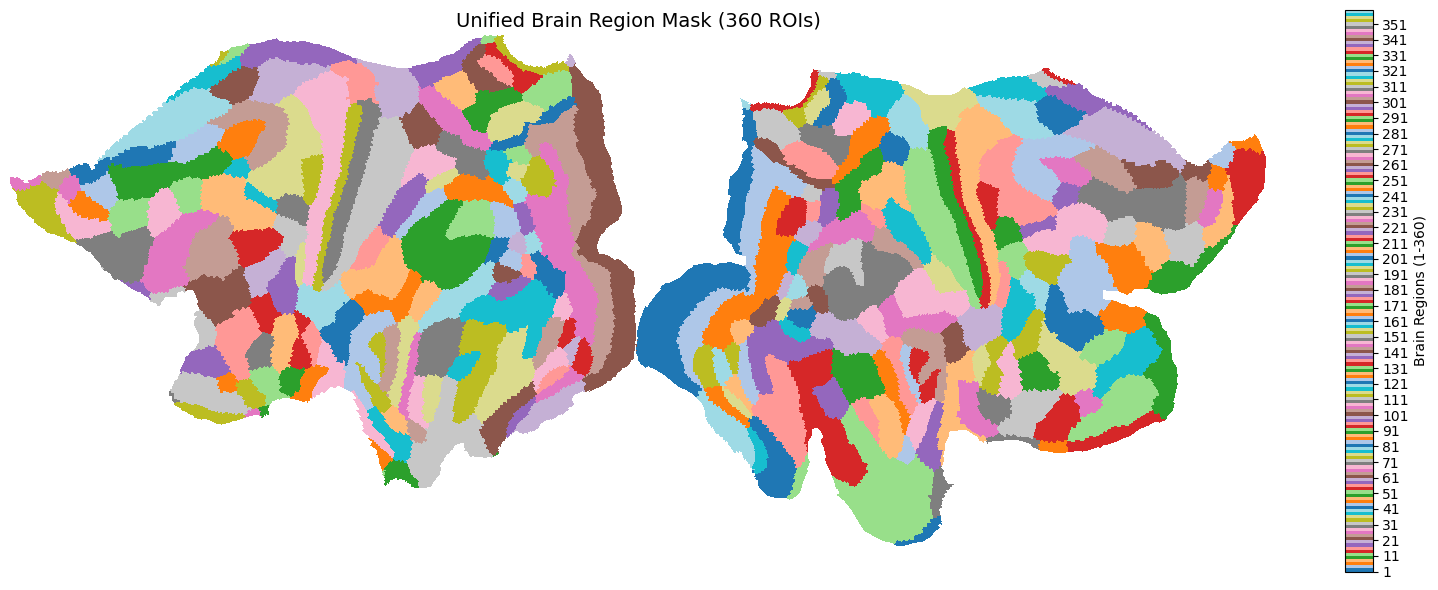

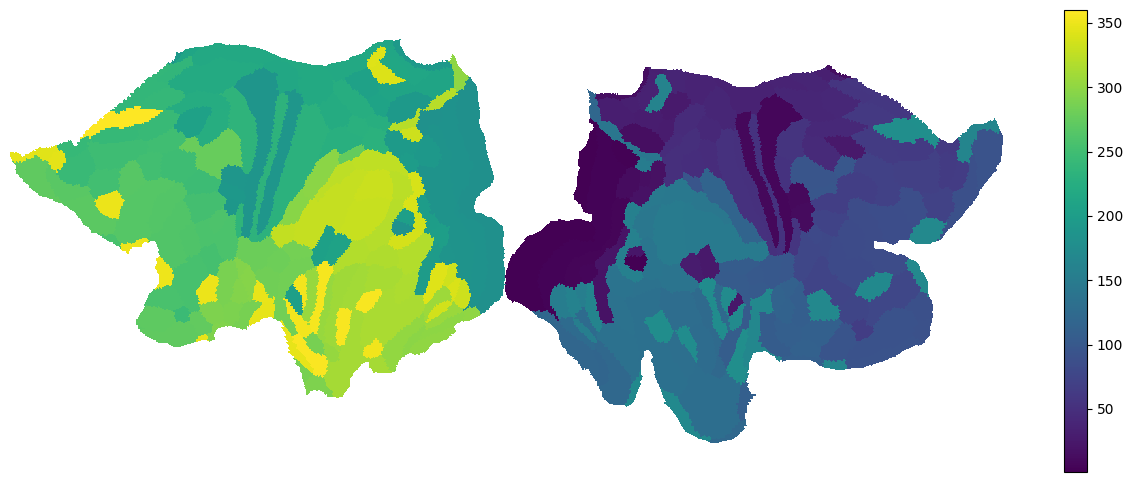

In [42]:
# Section 1: Load and Visualize Full Brain Mask with 360 ROIs
# -------------------------------------------------------------------
# Load the brain mask file containing ROI data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd

# Load the brain mask file containing ROI data
mask = np.load("../NSD/cortex_roi.npz")['images'][0] 
H, W = mask.shape

# Construct a discrete colormap for 360 ROIs
n_regions = 180
colors = plt.cm.tab20(np.linspace(0, 1, 20)) 
repeated_colors = np.vstack([colors] * (n_regions // 20 + 1))
discrete_cmap = ListedColormap(repeated_colors[:n_regions])

# Create a masked image with non-brain areas set to NaN
image_data = np.where(mask != 0, mask, np.nan)

# Visualize the brain regions with 360 ROIs
cmap = discrete_cmap
cmap.set_bad(color='white')
fig, ax = plt.subplots(figsize=(16, 6))
cax = ax.imshow(image_data, cmap=cmap, interpolation='none')
fig.colorbar(cax, ticks=np.arange(1, 361, 10), label="Brain Regions (1-360)") 
ax.axis('off') 
plt.title("Unified Brain Region Mask (360 ROIs)", fontsize=14)
plt.tight_layout()
plt.show()

# Visualize with a different colormap
cmap = plt.cm.viridis
cmap.set_bad(color='white')
fig, ax = plt.subplots(figsize=(16, 6)) 
cax = ax.imshow(image_data, cmap=cmap, interpolation='none')
fig.colorbar(cax)
ax.axis('off')
fig.show()

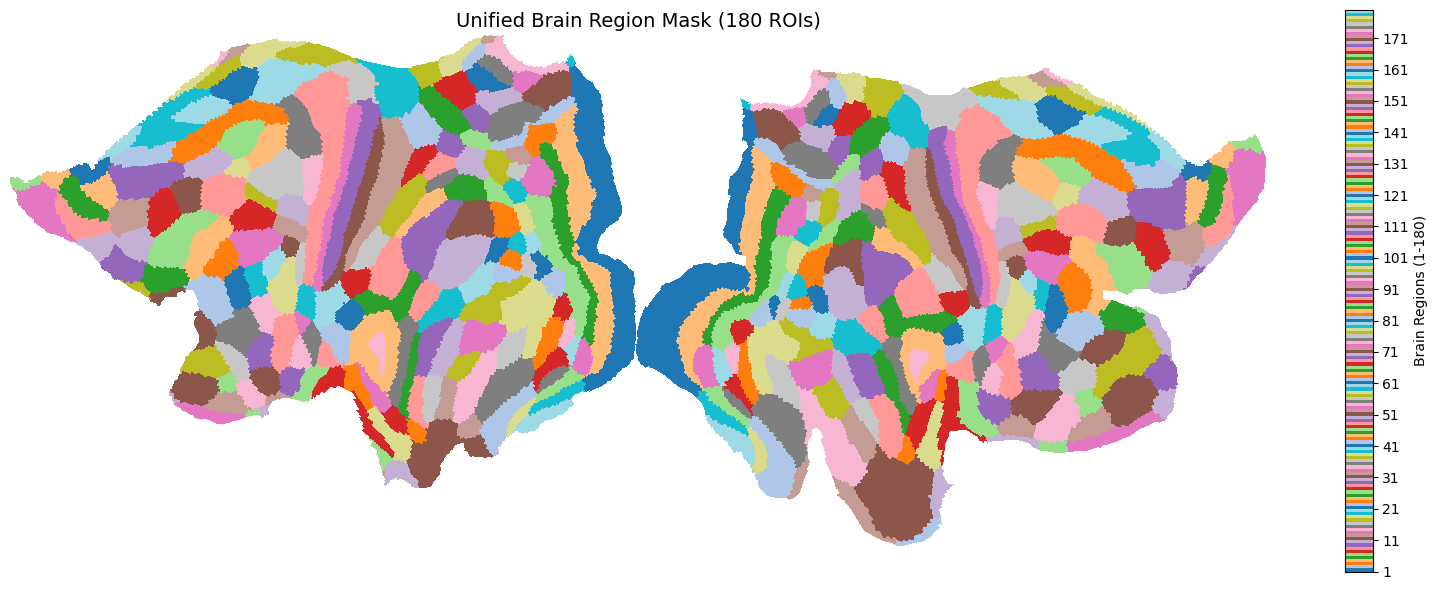

In [43]:
# Section 2: Merge Left and Right Hemisphere ROIs
# -------------------------------------------------------------------
# Combine left and right hemispheres, treating the same ROI as a single region
new_mask = mask.copy()
for i in range(1, 181):
    left_label = i
    right_label = i + 180
    new_mask[mask == right_label] = left_label

# Construct colormap for 180 unified ROIs
n_regions = 180
colors = plt.cm.tab20(np.linspace(0, 1, 20))
repeated_colors = np.vstack([colors] * (n_regions // 20 + 1)) 
discrete_cmap = ListedColormap(repeated_colors[:n_regions])

# Create masked image for 180 ROIs
image_data = np.where(mask != 0, new_mask, np.nan) 
cmap = discrete_cmap
cmap.set_bad(color='white')

# Visualize the unified brain mask with 180 ROIs
fig, ax = plt.subplots(figsize=(16, 6))
cax = ax.imshow(image_data, cmap=cmap, interpolation='none')
fig.colorbar(cax, ticks=np.arange(1, 181, 10), label="Brain Regions (1-180)")
ax.axis('off')
plt.title("Unified Brain Region Mask (180 ROIs)", fontsize=14)
plt.tight_layout()
plt.show()

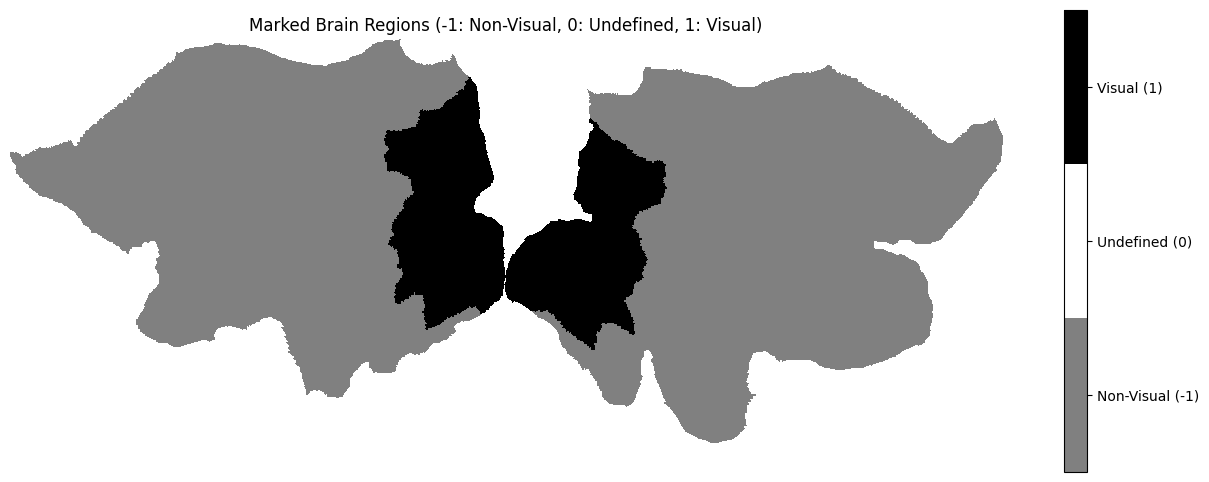

In [44]:
# Section 3: Extract Visual Cortex (VC) ROIs
# -------------------------------------------------------------------
# Load the ROI mapping from CSV
csv_path = "../NSD_full_brain/HCP_ROIs.csv"
csv_data = pd.read_csv(csv_path)
roi_names = csv_data['name'].tolist() 
# Create a dictionary mapping ROI names to indices
roi_dict = {name: idx for idx, name in enumerate(roi_names, 1)}

# Define the list of visual cortex ROI names
vc_roi_names = ['V1', 'V2', 'V3', 'V3A', 'V3B', 'V3CD', 'V4', 'LO1', 'LO2', 'LO3', 'PIT', 'V4t', 'V6', 'V6A', 'V7', 'V8', 'PH', 'FFC', 'IP0', 'MT', 
'MST', 'FST', 'VVC', 'VMV1', 'VMV2', 'VMV3', 'PHA1', 'PHA2', 'PHA3', 'TE2p', 'IPS1']

# Create a binary mask for visual cortex regions
marked_mask = np.zeros_like(mask)
for roi_name in roi_names:
    region_id = roi_dict[roi_name]
    region_name = roi_name.split('_')[1]  # Extract region name without hemisphere prefix
    if region_name in vc_roi_names:
        marked_mask[mask == region_id] = 1 # Mark visual cortex regions
    else:
        marked_mask[mask == region_id] = -1 # Mark non-visual regions

# Save the visual cortex mask
np.save('vc_roi.npy', marked_mask)

# Visualize the marked brain regions
cmap = ListedColormap(['gray', 'white', 'black'])
bounds = [-1.5, -0.5, 0.5, 1.5]
plt.figure(figsize=(16, 6))
plt.imshow(marked_mask, cmap=cmap, interpolation='none')
plt.title("Marked Brain Regions (-1: Non-Visual, 0: Undefined, 1: Visual)")
plt.axis('off')
cbar = plt.colorbar(ticks=[-1, 0, 1], boundaries=bounds, orientation='vertical')
cbar.ax.set_yticklabels(['Non-Visual (-1)', 'Undefined (0)', 'Visual (1)'])
plt.show()

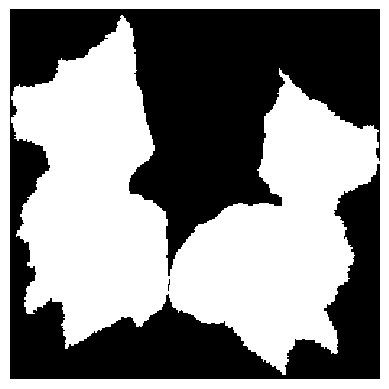

In [45]:
# Section 4: Crop and Resize Visual Cortex ROI Mask
# -------------------------------------------------------------------
# Crop and resize the visual cortex mask to 256x256

import cv2

image_size=(256, 256)
# Load mask and define VC and foreground masks
mask = marked_mask.copy()
H, W = mask.shape
vc_mask = mask == 1 # [H, W]
fg_mask = (mask == 1) | (mask == -1) # [H, W]

# Generate grid coordinates
x = np.linspace(0, W-1, W)
y = np.linspace(0, H-1, H)
xx, yy = np.meshgrid(x, y)
grid = np.stack([xx, yy], axis=0) # [2, H, W]

# Determine bounding box for VC region
gird_ = grid * vc_mask[np.newaxis]
x1 = min(int(gird_[0].max()) + 1, W)
y1 = min(int(gird_[1].max()) + 10, H)
gird_[gird_ == 0] = 1e6
x0 = max(int(gird_[0].min() - 1), 0)
y0 = max(int(gird_[1].min() - 10), 0)

# Define bounding box coordinates
vc_mask = vc_mask
fg_mask = fg_mask
coord = [x0, x1, y0, y1]

# Crop and resize the VC mask for later transformations
crop_msk = vc_mask[coord[2]:coord[3] + 1, coord[0]:coord[1] + 1]
cmask = cv2.resize(crop_msk * 1., (image_size[1], image_size[0]), interpolation=cv2.INTER_NEAREST)

plt.figure()
plt.imshow(cmask, cmap='gray', interpolation='none')
plt.axis('off') 
plt.show()

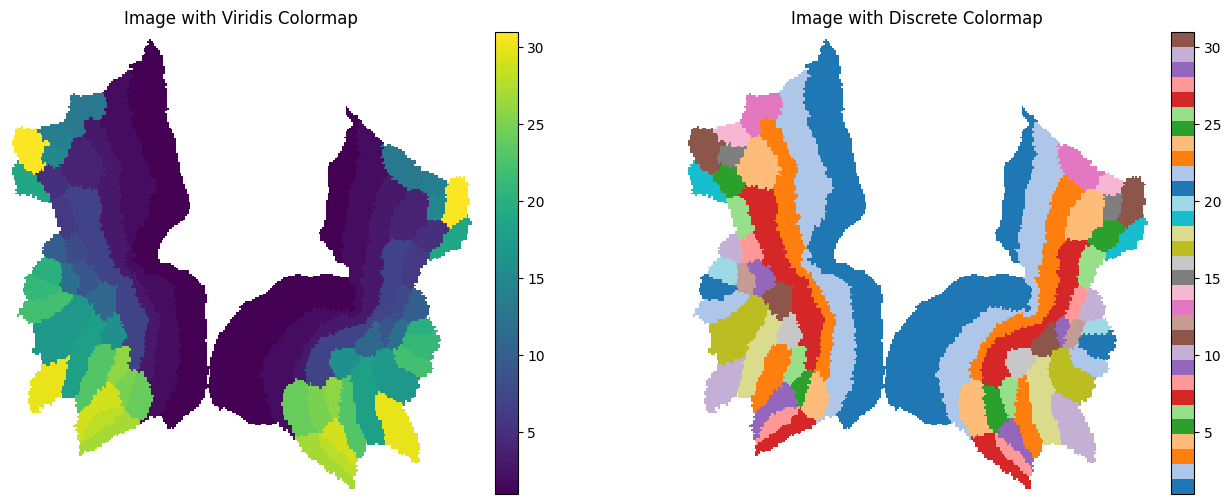

In [46]:
# Section 5: Crop and Resize Visual Cortex ROI Mask 
# an example for generating ../NSD/vc_masks.npy. Retain the level value for each ROI.
import pandas as pd

mask = np.load("../NSD/cortex_roi.npz")['images'][0]  # 假设文件路径正确
H, W = mask.shape

# Load the ROI mapping from CSV
csv_path = "../NSD_full_brain/HCP_ROIs.csv"
csv_data = pd.read_csv(csv_path)
roi_names = csv_data['name'].tolist()  # 获取 CSV 中的 ROI 名称列表
roi_dict = {name: idx for idx, name in enumerate(roi_names, 1)}

# List of VC ROI names in the brain.
vc_roi_names = ['V1', 'V2', 'V3', 'V3A', 'V3B', 'V3CD', 'V4', 'LO1', 'LO2', 'LO3', 'PIT', 'V4t', 'V6', 'V6A', 'V7', 'V8', 'PH', 'FFC', 'IP0', 'MT', 
'MST', 'FST', 'VVC', 'VMV1', 'VMV2', 'VMV3', 'PHA1', 'PHA2', 'PHA3', 'TE2p', 'IPS1']
vc_roi_dict = {name: idx for idx, name in enumerate(vc_roi_names, 1)}


# Create a binary mask for visual cortex regions
vc_mask = np.zeros_like(mask)
for roi_name in roi_names:
    region_id = roi_dict[roi_name]
    region_name = roi_name.split('_')[1]
    if region_name in vc_roi_names:
        vc_mask[mask == region_id] = vc_roi_dict[region_name]
        

# Crop and resize the input image based on the VC mask.
# Set values outside the VC mask to 0.
vc_mask = vc_mask[coord[2]:coord[3] + 1, coord[0]:coord[1] + 1]
vc_mask = cv2.resize(vc_mask, (image_size[1], image_size[0]), interpolation=cv2.INTER_NEAREST)

np.save('vc_masks.npy', vc_mask)

# Visualize the marked brain regions
vc_mask[cmask == 0] = np.nan

cmap1 = plt.cm.viridis
cmap1.set_bad(color='white')

n_regions = 31
colors = plt.cm.tab20(np.linspace(0, 1, 20))
repeated_colors = np.vstack([colors] * (n_regions // 20 + 1))
discrete_cmap = ListedColormap(repeated_colors[:n_regions])
cmap2 = discrete_cmap
cmap2.set_bad(color='white')

fig, axes = plt.subplots(1, 2, figsize=(16, 6)) 

cax1 = axes[0].imshow(vc_mask, cmap=cmap1, interpolation='none')
axes[0].axis('off')
fig.colorbar(cax1, ax=axes[0], fraction=0.046, pad=0.04) 
axes[0].set_title("Image with Viridis Colormap")

cax2 = axes[1].imshow(vc_mask, cmap=cmap2, interpolation='none')
axes[1].axis('off')
fig.colorbar(cax2, ax=axes[1], fraction=0.046, pad=0.04) 
axes[1].set_title("Image with Discrete Colormap")

plt.show()